# Neural Network Example (Manual & Keras)

We aim to demonstrate a simple neural network with one hidden layer using simulated data. We implement the neural network manually, and then compare against a similarly constructed neural network in Keras.

Our input data for each observation will be a random array of length $ N = 10$ taking values in $(-1,0,1)$. The single-valued simulated output will be constructed via the function **y_func**. The aim of this function is to create a highly nonlinear relationship between the input array and the output. The model will be trained 'online' such that the weights are updated at each new observation that the model sees.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define our function to simulate the output
def y_func(x):
    result = 0
    for i in range(0,len(x)):
        if i%2 == 0:
            if i%4 == 0:
                result *= 0.5 / (3.5 + x[i])
            else:                    
                result += 0.5 * x[i]
        else:
            result -=  x[i] / (2 + x[i])
    
    return result
            

In [3]:
# create our random vectors of inputs
x_data = []
numObs = 1000
for _ in range(0,numObs):
    x_data.append(np.random.randint(low = -1, high = 2, size = 10) )

# compute the output from the input    
y_data = [y_func(x) for x in x_data]

x_data = np.array(x_data)
y_data = np.array(y_data)
    

### Activation Functions

The mapping from the input array $X$ to a given node $Z_i$ in the hidden layer will be given by

$$ Z_i = \sigma (a_i + \alpha_i^T X ) $$

where $\sigma (x) := 1 / (1 + e^{-x})$ and the scalar $a_i$ and vector $\alpha_i$ are the bias and weights respectively.

The output $Y$ is just a linear combination (with weights $\beta$ and bias $b$) of the nodes in the hidden layer

$$ Y = b + \beta^T Z $$

Hence our mapping (with a hidden layer of $K$ nodes) will be given in full by

$$ Y = b + \sum_{i=1}^K \beta_i * \sigma(a_i + \alpha_i^T X) $$

### Cost function and derivatives

We define our cost function as the usual squared error between our prediction $\hat{Y}$ and the true value $Y$

$$ C(Y, \hat{Y}) := (Y - \hat{Y})^2 $$

In order to minimise the cost function using gradient descent, we will need to compute the derivatives with respect to the weights in the model. These can easily be shown to be

$$\frac{\partial C}{\partial \beta_i} = -2(Y - \hat{Y})Z_i$$

$$\frac{\partial C}{\partial \alpha_{ik}} = -2(Y - \hat{Y}) \beta_i  \sigma ' (a_i + \alpha_i^T X)X_k $$

In practice, when we calculate these derivatives, we will append a value of $1$ onto the input vector $X$ (and subsequently for $Z$) and include the bias in the weight vector. This allows the bias to be updated in the same way as the weights on each iteration.

### Gradient Descent

Gradient descent will be computed as follows

$$\beta_i^{(r+1)} = \beta_i^{(r)} - \gamma \frac{\partial C}{\partial \beta_i}$$
$$\alpha_{ik}^{(r+1)} = \alpha_{ik}^{(r)} - \gamma \frac{\partial C}{\partial \alpha_{ik}}$$

where $\gamma$ is the learning rate.

In [4]:
# define the sigmoid function and its derivative
def sigmoid_func(x):
    return 1.0 / (1 + np.exp(-x))

def sigmoid_func_deriv(x):
    return np.exp(-x) / (1 + np.exp(-x))**2
    

In [5]:
class neuralNet:
    
    def __init__(self, num_layer_nodes, input_data_len, output_data_len):
        
        # we add an extra element to the weight vector to hold the bias
        self.w1 = np.random.rand(num_layer_nodes,input_data_len + 1)
        self.w2 = np.random.rand(num_layer_nodes + 1)
        
        # layer_vals and output_vals will hold our hidden layer values and output values respectively
        self.layer_vals  = np.zeros(num_layer_nodes)
        self.output_vals = 0
        
        # the weight change matrices for the gradient descent
        self.w1_change = np.zeros( (num_layer_nodes, input_data_len + 1) )
        self.w2_change = np.zeros(num_layer_nodes + 1)
        
    def train(self, input_data, output_data):
        
        #append our input array with 1 to account for bias in first weight vector
        input_data_bias = np.append(input_data,[1])
        
        self.layer_vals  = sigmoid_func(np.dot(self.w1,input_data_bias))
        
        #append our input array with 1 to account for bias in second weight vector
        self.layer_vals = np.append(self.layer_vals,[1])
        
        self.output_vals = np.dot(self.w2, self.layer_vals)
        
        # compute the derivates
        self.w2_change = -2 * (output_data - self.output_vals) * self.layer_vals
        
        for i in range(0, len(self.w1_change)):
            for j in range(0,len(self.w1_change[1])):
                self.w1_change[i][j] = -2 * (output_data - self.output_vals) * self.w2[i] * sigmoid_func_deriv(np.dot(self.w1[i], input_data_bias)) * input_data_bias[j]
        
        # update via gradient descent
        self.w1 = self.w1  - 0.05 * self.w1_change
        self.w2 = self.w2  - 0.05 * self.w2_change
        
    def predict(self, input_data):              
        
        self.layer_vals  = sigmoid_func(np.dot(self.w1,np.append(input_data,[1])  ))
        self.output_vals = np.dot(self.w2, np.append(self.layer_vals,[1]))
        
        return self.output_vals       
        
        
        

In [6]:
# initialise a NN with 10 nodes in the hidden layer
nn = neuralNet(10,10,1)

# we will iterate 100 times through the data (which has 1000 observations -> 200 of which will be kept for testing)
epochs = 100

cost = np.zeros(epochs)
test_error = np.zeros(epochs)

train_set_len = 800 #keep 200 observations for testing
fitted_vals = np.zeros(train_set_len)
test_predictions = np.zeros(numObs - train_set_len)

for i in range(0,epochs):
    
    fitted_vals = np.zeros(train_set_len)
    
    for j in range(0,train_set_len):
        
        nn.train(x_data[j], y_data[j])
        fitted_vals[j] = nn.predict(x_data[j])
        
    for k in range(0, numObs - train_set_len):
        test_predictions[k] = nn.predict(x_data[train_set_len + k])      
          
        
    cost[i] = sum( (y_data[0:train_set_len] - fitted_vals)**2 )
    test_error[i] = sum( (y_data[train_set_len:] - test_predictions)**2 )
    
    


### Training Set & Test Set Loss Function

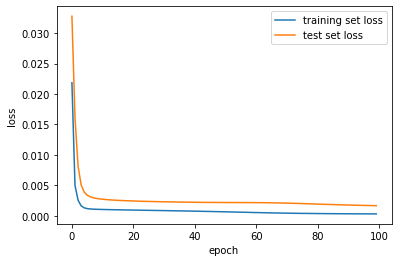

In [7]:
plt.figure()
plt.plot(cost/train_set_len, label = 'training set loss')
plt.plot(test_error/(numObs - train_set_len), label = 'test set loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Trained Model Test Set Predictions

In [8]:
predict_vals = []
for i in range(train_set_len,len(y_data)):
    predict_vals.append(nn.predict(x_data[i]))

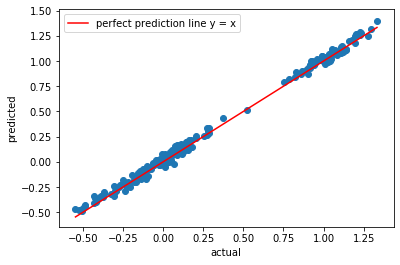

In [9]:
testSet = y_data[train_set_len:]
lineStart = min(y_data[train_set_len:])
lineEnd = max(y_data[train_set_len:])

plt.figure()
plt.scatter(testSet, predict_vals)
plt.plot([lineStart,lineEnd],[lineStart,lineEnd], color = 'r', label = 'perfect prediction line y = x')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.legend()
plt.show()

(array([ 1.,  0.,  2.,  0.,  4.,  7., 14.,  8.,  6., 14., 11., 11., 20.,
        25., 28., 17., 13., 11.,  2.,  6.]),
 array([-0.08582935, -0.07707003, -0.06831071, -0.05955139, -0.05079207,
        -0.04203274, -0.03327342, -0.0245141 , -0.01575478, -0.00699546,
         0.00176386,  0.01052318,  0.0192825 ,  0.02804183,  0.03680115,
         0.04556047,  0.05431979,  0.06307911,  0.07183843,  0.08059775,
         0.08935708]),
 <a list of 20 Patch objects>)

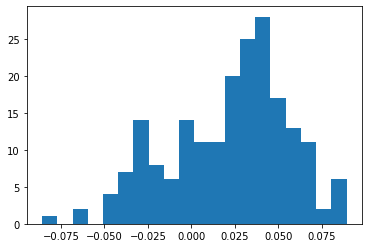

In [10]:
residuals = predict_vals - testSet
plt.hist(residuals, bins = 20)

## Keras Implementation

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

Using TensorFlow backend.


In [13]:
model = Sequential()
model.add(Dense(10, activation='sigmoid', input_dim=10)) #sigmoid activation layer with 10 nodes
model.add(Dense(1, activation='linear')) #linear activation to single valued output
model.compile(optimizer='sgd',
              loss='mse',
              metrics=['accuracy'])

fitted_model = model.fit(x_data[0:train_set_len], y_data[0:train_set_len],validation_data = (x_data[train_set_len:],y_data[train_set_len:]), epochs=100, batch_size=1, verbose = 0)

### Keras Training Set & Test Set Loss Function

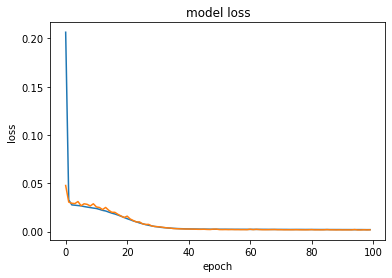

In [14]:
plt.figure()
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

### Keras Trained Model Test Set Predictions

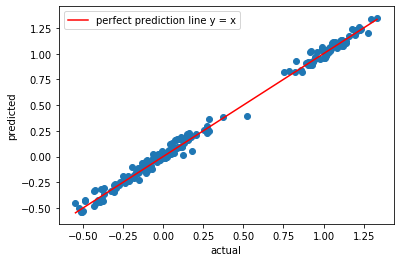

In [15]:
predict_vals_keras = model.predict(x_data[train_set_len:])

plt.figure()
plt.scatter(testSet, predict_vals_keras)
plt.plot([lineStart,lineEnd],[lineStart,lineEnd], color = 'r', label = 'perfect prediction line y = x')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.legend()
plt.show()